# Remote Sensing of Riparian Buffer Ecological Effects
---
## Abstract
Riparian Buffer Systems refer to vegetation growing along rivers which fulfill an important ecological role:  they filter non-point source pollution such as fertilizer containing farm runoff and help prevent undesirable ecological effects downstream.  Such effects include algal blooms and creation of dead zones in oceans and lakes, adversely effecting animal and human life as well as local economies which depend on fishing and tourism.  This notebook demonstrates how to perform GIS-based analyses using Open Data Cube to investigate such systems.  Specifically, this notebook presents several methods of integrating non-GIS and GIS data (laboratory based chemical analyses of water, as well as GIS based sensing of vegetation and Total Suspended Matter) by using the Elizabeth River in Virginia and the Chesapeake Bay as an example.  This notebook also presents and demonstrates an algorithm for identifying riparian zones and calculating NDVI indexes for them. 


## [Index](#Index)
* [Introduction](#Introduction-%E2%96%B4)
* [Background](#)
    * [History](#History)
    * [Riparian Buffer Zones](#Riparian-Buffer-Zones)
* [Configuration and Dependencies](#Configuration-and-Dependencies-%E2%96%B4)
* [Landsat 8 Data](#Landsat-8-Data-%E2%96%B4)
    * [Total Suspended Matter (TSM)](#Total-Suspended-Matter-(TSM))
    * [Mean Total Suspended Matter (TSM) Per Pixel](#Mean-Total-Suspended-Matter-(TSM)-Per-Pixel)
    * [Normalized Difference Vegetation Index (NDVI)](#Normalized-Difference-Vegetation-Index-(NDVI))
* [References](#References-%E2%96%B4)
    
---
![riparian Image](imgs/buffer_image.png)  Image from (Cunningham, Stuhlinger, and Liechty, n.d.) [1]

## [Configuration and Dependencies &#9652;](#Index)
Before we attemnpt to analyze any data, we must first setup our programming enviroment by importing any Python libraries we may need for our analysis. Below we add the folium library, which we will use to display maps in the notebook, as well as the numpy, xarray, and pandas libraries which we will use to manipulate our data. The seaborn and matplotlib libraries are used to plot and graphicaly display our results.

In [1]:
import sys
sys.path.append("..") #Required to use Data Cube utilities

import warnings

import folium
import folium.plugins
import numpy as np
import xarray as xr
import pandas as pd
pd.options.display.max_columns = None

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "axes.grid": True,
    "lines.linewidth": 2,
    "figure.dpi": 300
}
pylab.rcParams.update(params)

import utils.data_cube_utilities.data_access_api as dc_api
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_water_quality import tsm
from utils.data_cube_utilities.plotter_utils import figure_ratio
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
from utils.data_cube_utilities.vegetation import NDVI
api = dc_api.DataAccessApi()

from odc_gee.earthengine import Datacube as GEE_Datacube
import os
dc = GEE_Datacube()

# [Landsat 8 Data &#9652;](#Index)
---
The Landsat 8 is an earth observation satellite administered jointly by NASA and the USGS. Launched in 2013, it has both visible and infrared sensors with resolution ranging from 15 to 100 meters. In this section, we use multispectral images taken by Landst 8 to compute the Total Suspended Matter and Normalized Difference Vegetation Index around the Elizabeth River.

In [2]:
# Elizabeth River, VA #
# area_name = 'Elizabeth River'
# lat = (36.9664, 36.7218)
# lon = (-76.4351, -76.1591)
# full_time_rng = ("2020-01-01", "2020-12-31")

# Nansemond and Elizabeth Rivers, VA #
# area_name = 'Nansemond and Elizabeth Rivers'
# lat = (36.758187, 36.960384)
# lon = (-76.535258, -76.211527)
# full_time_rng = ("2018-01-01", "2020-12-31")

# Lima, Peru #
area_name = 'Peru'
lat = (-12.206678, -12.162618)
lon = (-77.059790, -77.031870)
full_time_rng = ("2019-01-01", "2020-12-31")

# Izmir, Turkey #
# area_name = 'Izmir'
# full_time_rng = ("2020-01-01", "2020-12-31")
# Bay of Izmir, East
# lat = (38.403150, 38.471187)
# lon = (27.097850, 27.171836)
# Bay of Izmir, Full
# lat = (38.317787, 38.732612)
# lon = (26.508640, 27.146985)

In [3]:
measurements = ["red", "green", "blue", "nir", "swir1", "swir2"]
dask_chunks_std = dict(latitude=1000, longitude=1000, time=200)
ls8_products = ['ls8_l2_c1_t1_google'] #, 'ls8_l2_c1_t2_google'
ls_data = []
for product in ls8_products:
    # Get the clean mask to determine which times have enough 
    # good data to warrant loading data for.
    try:
        times = dc.load(product=product, 
                        lat=lat, lon=lon, 
                        time=full_time_rng, measurements=[],
                        group_by='solar_day',
                        dask_chunks=dask_chunks_std).time.values
    except: # Nonexistant or corrupted data for this area.
        continue
    clean_mask = []
    for time in times:
        time = pd.to_datetime(time)
        try:
            slice_pqa = dc.load(product=product, 
                                lat=lat, lon=lon, 
                                time=(time, time+pd.Timedelta(1, 's')),
                                measurements=['pixel_qa'],
                                group_by='solar_day',
                                dask_chunks=dask_chunks_std).persist()
        except: # Nonexistant or corrupted data for this time and area.
            continue
        slice_clean_mask = landsat_qa_clean_mask(slice_pqa, 'LANDSAT_8', collection='c1', level='l2')
        if slice_clean_mask.mean().compute().values > 0.4:
            clean_mask.append(slice_clean_mask)
    clean_mask = xr.concat(clean_mask, 'time')
    times_to_load = clean_mask.time
    # Load and clean the data.
    product_data = []
    for time in times_to_load.values:
        time = pd.to_datetime(time)
        try:
            slice_data = dc.load(product=product, 
                        lat=lat, lon=lon, 
                        time=(time, time+pd.Timedelta(1, 's')), 
                        measurements=measurements,
                        group_by='solar_day',
                        dask_chunks=dask_chunks_std).where(clean_mask.sel(time=time)).persist()
        except: # Nonexistant or corrupted data for this time and area.
            continue
        product_data.append(slice_data)
    ls_data.append(xr.concat(product_data, 'time'))
ls_data = xr.concat(ls_data, 'time')

### Total Suspended Matter (TSM)

Total suspended matter is a measure of the amount of solid particulate mater suspended in the water. This measurement is calculated by comparing the reflectance in several select bands which change as more particulate matter becomes suspended. 

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    water_mask = wofs_classify(ls_data, no_data=0.0).wofs.astype(np.bool)
water_data = ls_data.where(water_mask).astype("int16")

In [5]:
tsm_data = tsm(water_data).chunk(dict(latitude=-1, longitude=-1, time=-1)).persist()
# Denoise.
tsm_data = tsm_data.where((tsm_data.quantile(0.001) < tsm_data) & \
                          (tsm_data < tsm_data.quantile(0.999))).persist()

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


### Mean Total Suspended Matter (TSM) Per Pixel

/env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


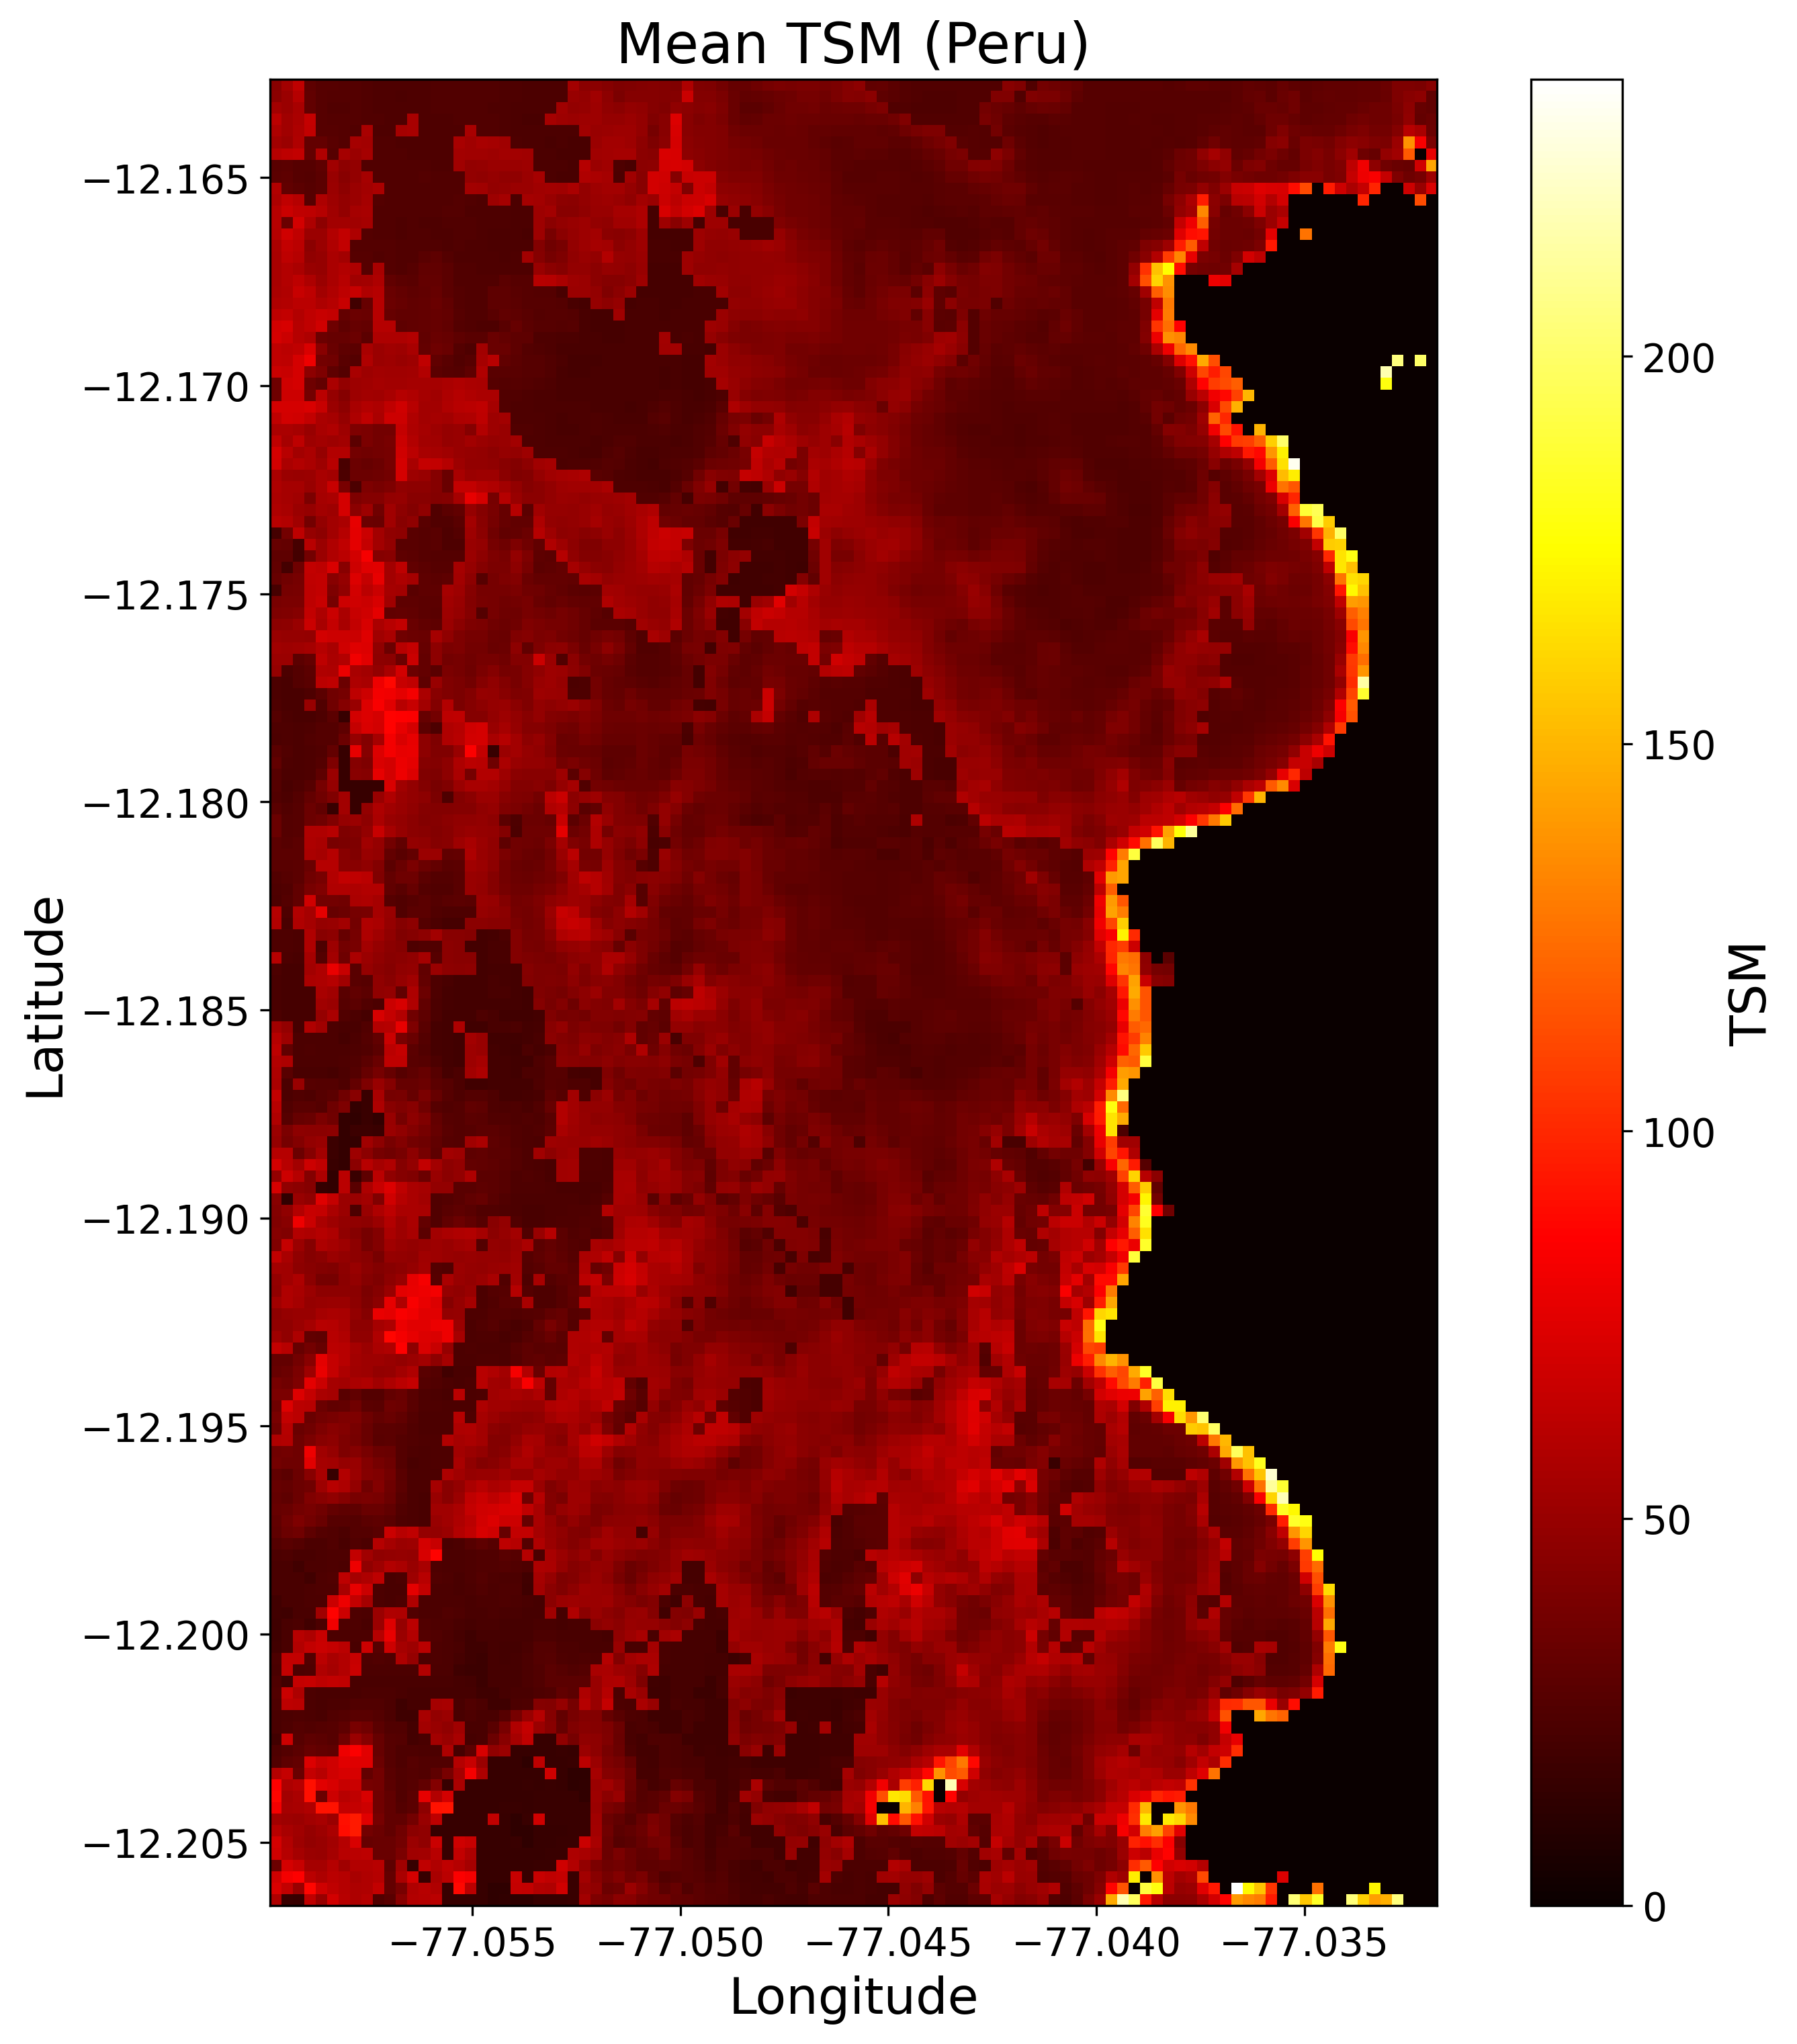

In [6]:
mean_tsm_per_pixel = tsm_data.mean(dim=["time"]).fillna(0).persist()

fig, axes = plt.subplots(nrows=1, figsize=(12, 12))

extent = [mean_tsm_per_pixel.longitude.min(),
      mean_tsm_per_pixel.longitude.max(),
      mean_tsm_per_pixel.latitude.min(),
      mean_tsm_per_pixel.latitude.max()]

im = axes.imshow(mean_tsm_per_pixel.tsm, cmap='hot', extent=extent)
axes.grid(False)
axes.set_title(f'Mean TSM ({area_name})')
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')
tsm_scale = fig.colorbar(im, ax=axes)
tsm_scale.set_label('TSM')
fig.savefig('mean_tsm.png')

### Max Total Suspended Matter (TSM) Per Pixel

/env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/env/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


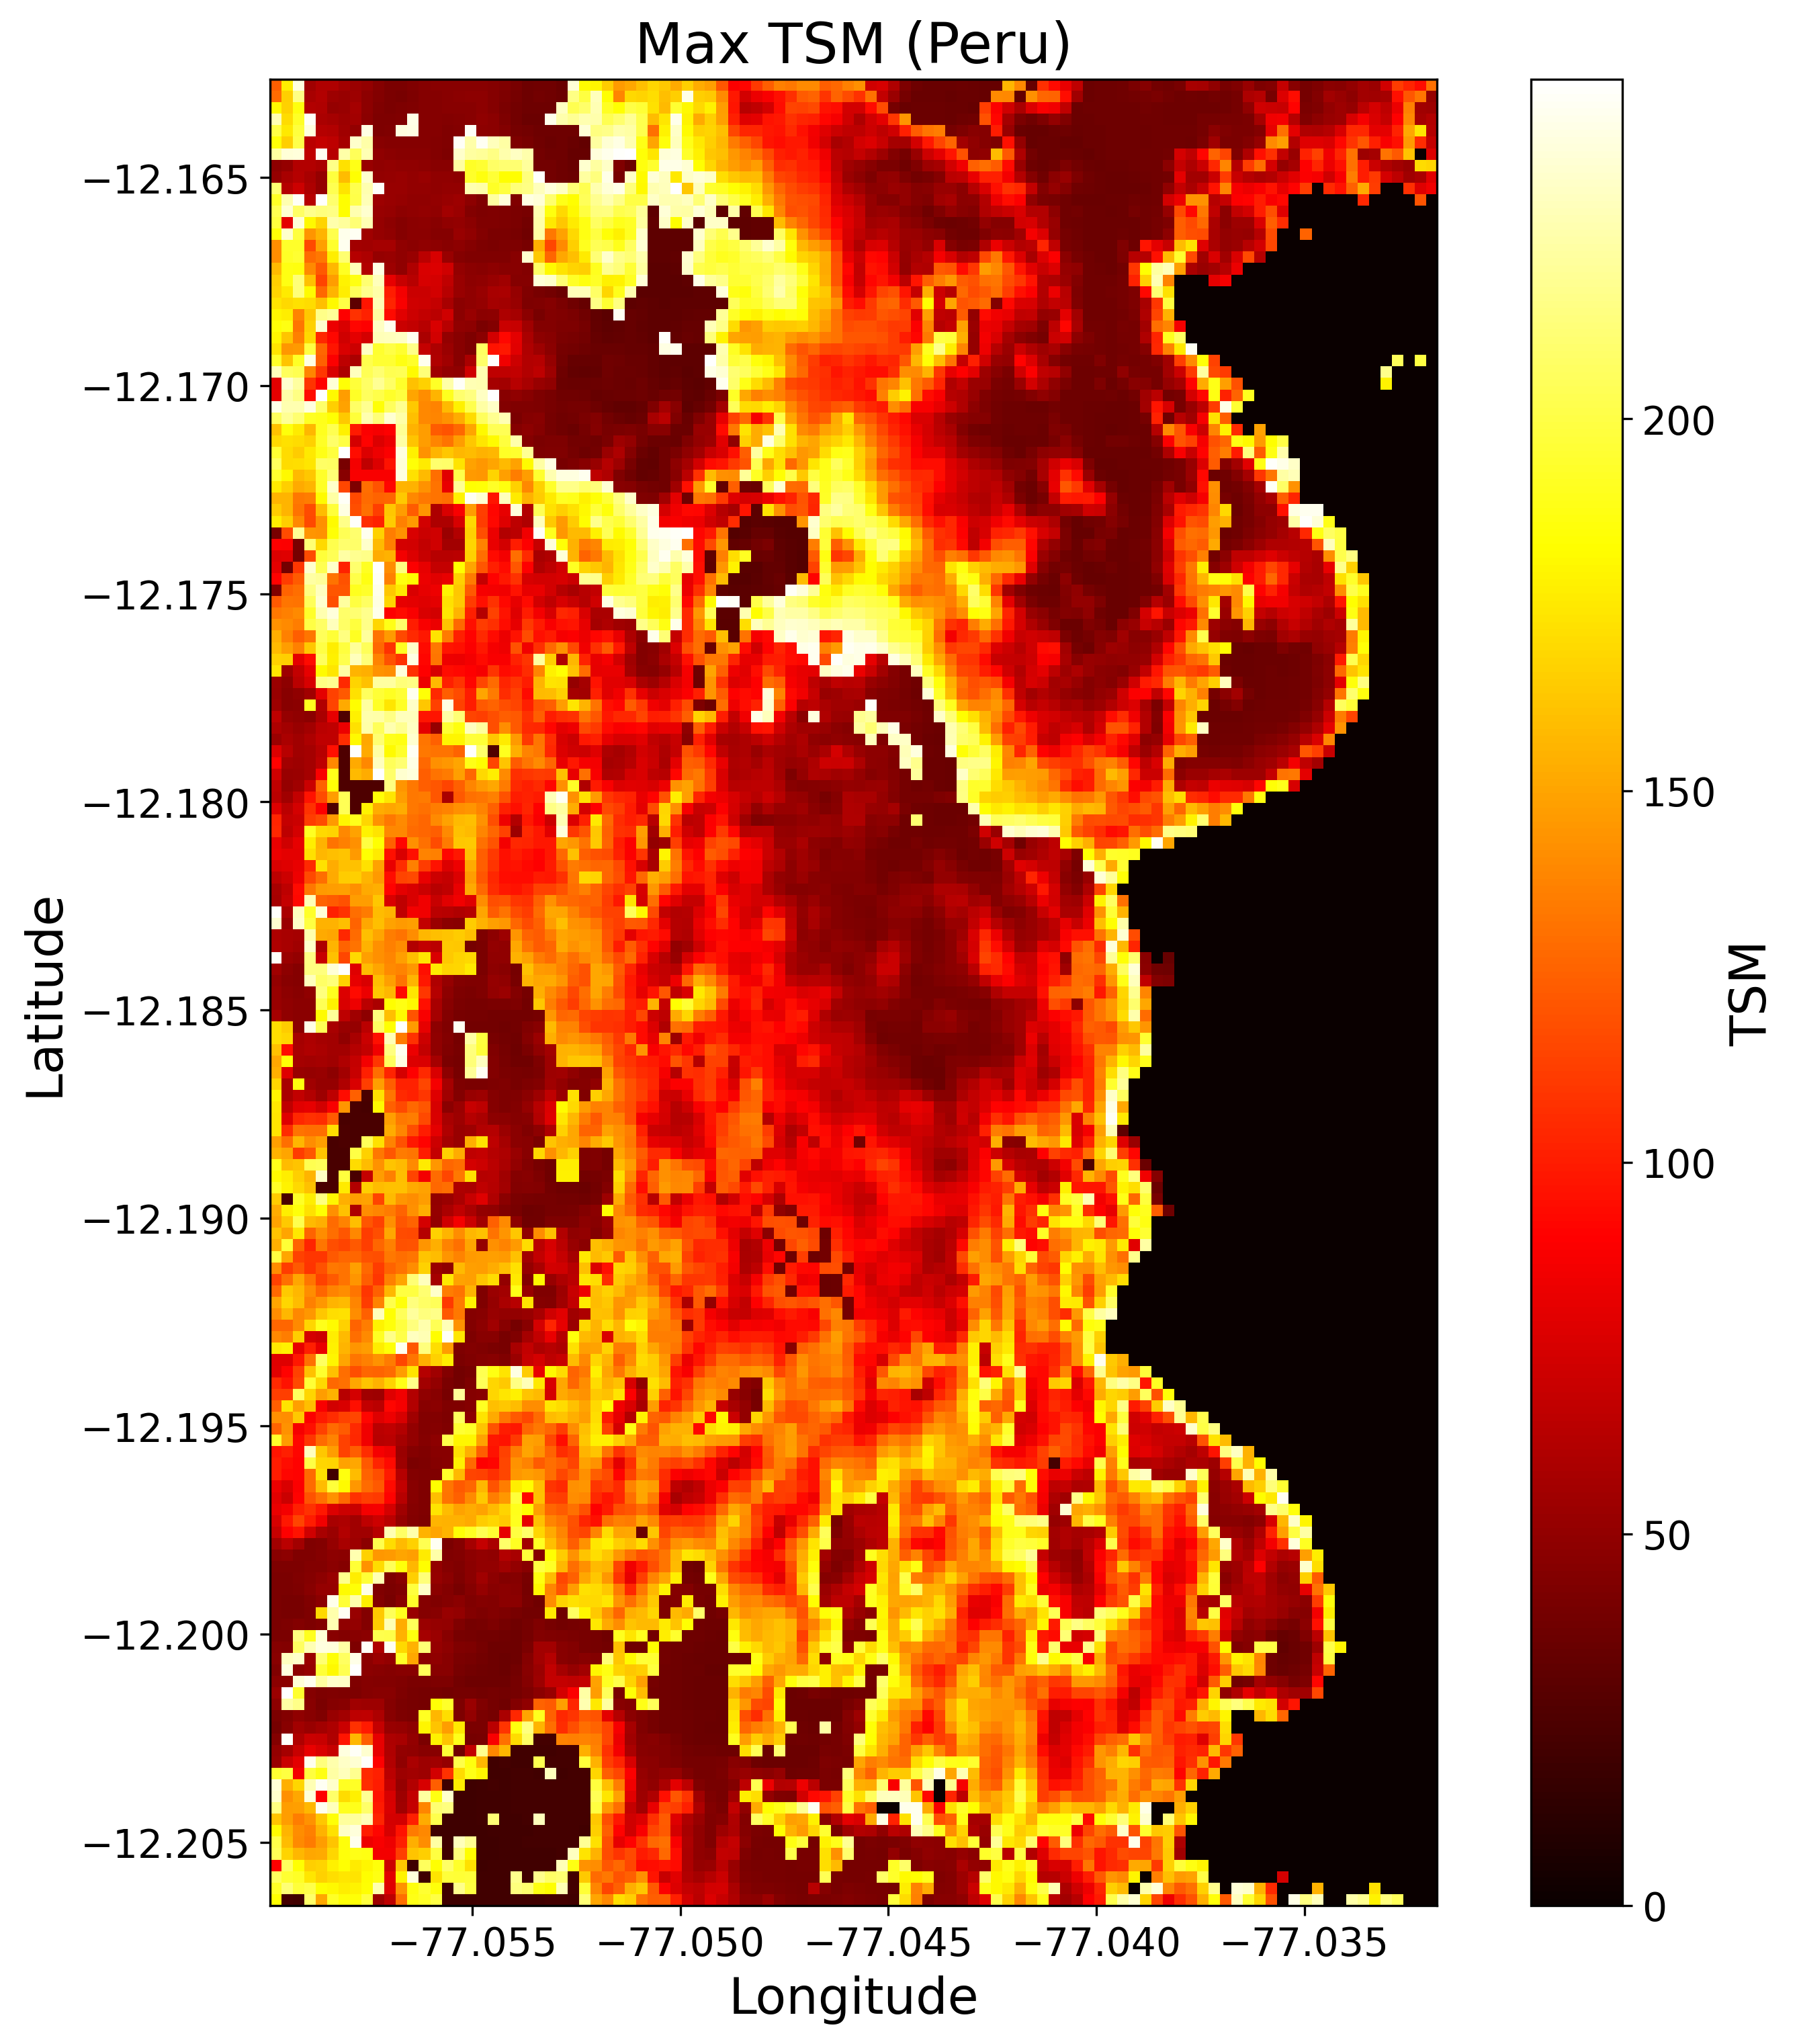

In [7]:
max_tsm_per_pixel = tsm_data.max(dim=["time"]).fillna(0).persist()

fig, axes = plt.subplots(nrows=1, figsize=(12, 12))

extent = [max_tsm_per_pixel.longitude.min(),
      max_tsm_per_pixel.longitude.max(),
      max_tsm_per_pixel.latitude.min(),
      max_tsm_per_pixel.latitude.max()]

im = axes.imshow(max_tsm_per_pixel.tsm, cmap='hot', extent=extent)
axes.grid(False)
axes.set_title(f'Max TSM ({area_name})')
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')
tsm_scale = fig.colorbar(im, ax=axes)
tsm_scale.set_label('TSM')
fig.savefig('max_tsm.png')

## Normalized Difference Vegetation Index (NDVI)

In [8]:
from skimage.morphology import disk, dilation
water_mask = water_mask.compute()
water_buffer_mask = water_mask.copy()
for i in range(len(water_buffer_mask)):
    water_buffer_mask[i] = xr.DataArray(dilation(water_mask[i], disk(10)), coords=water_mask[i].coords, 
                                        dims=['latitude', 'longitude'], name='wofs')
buffer_mask = xr.ufuncs.logical_xor(water_buffer_mask, water_mask)

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


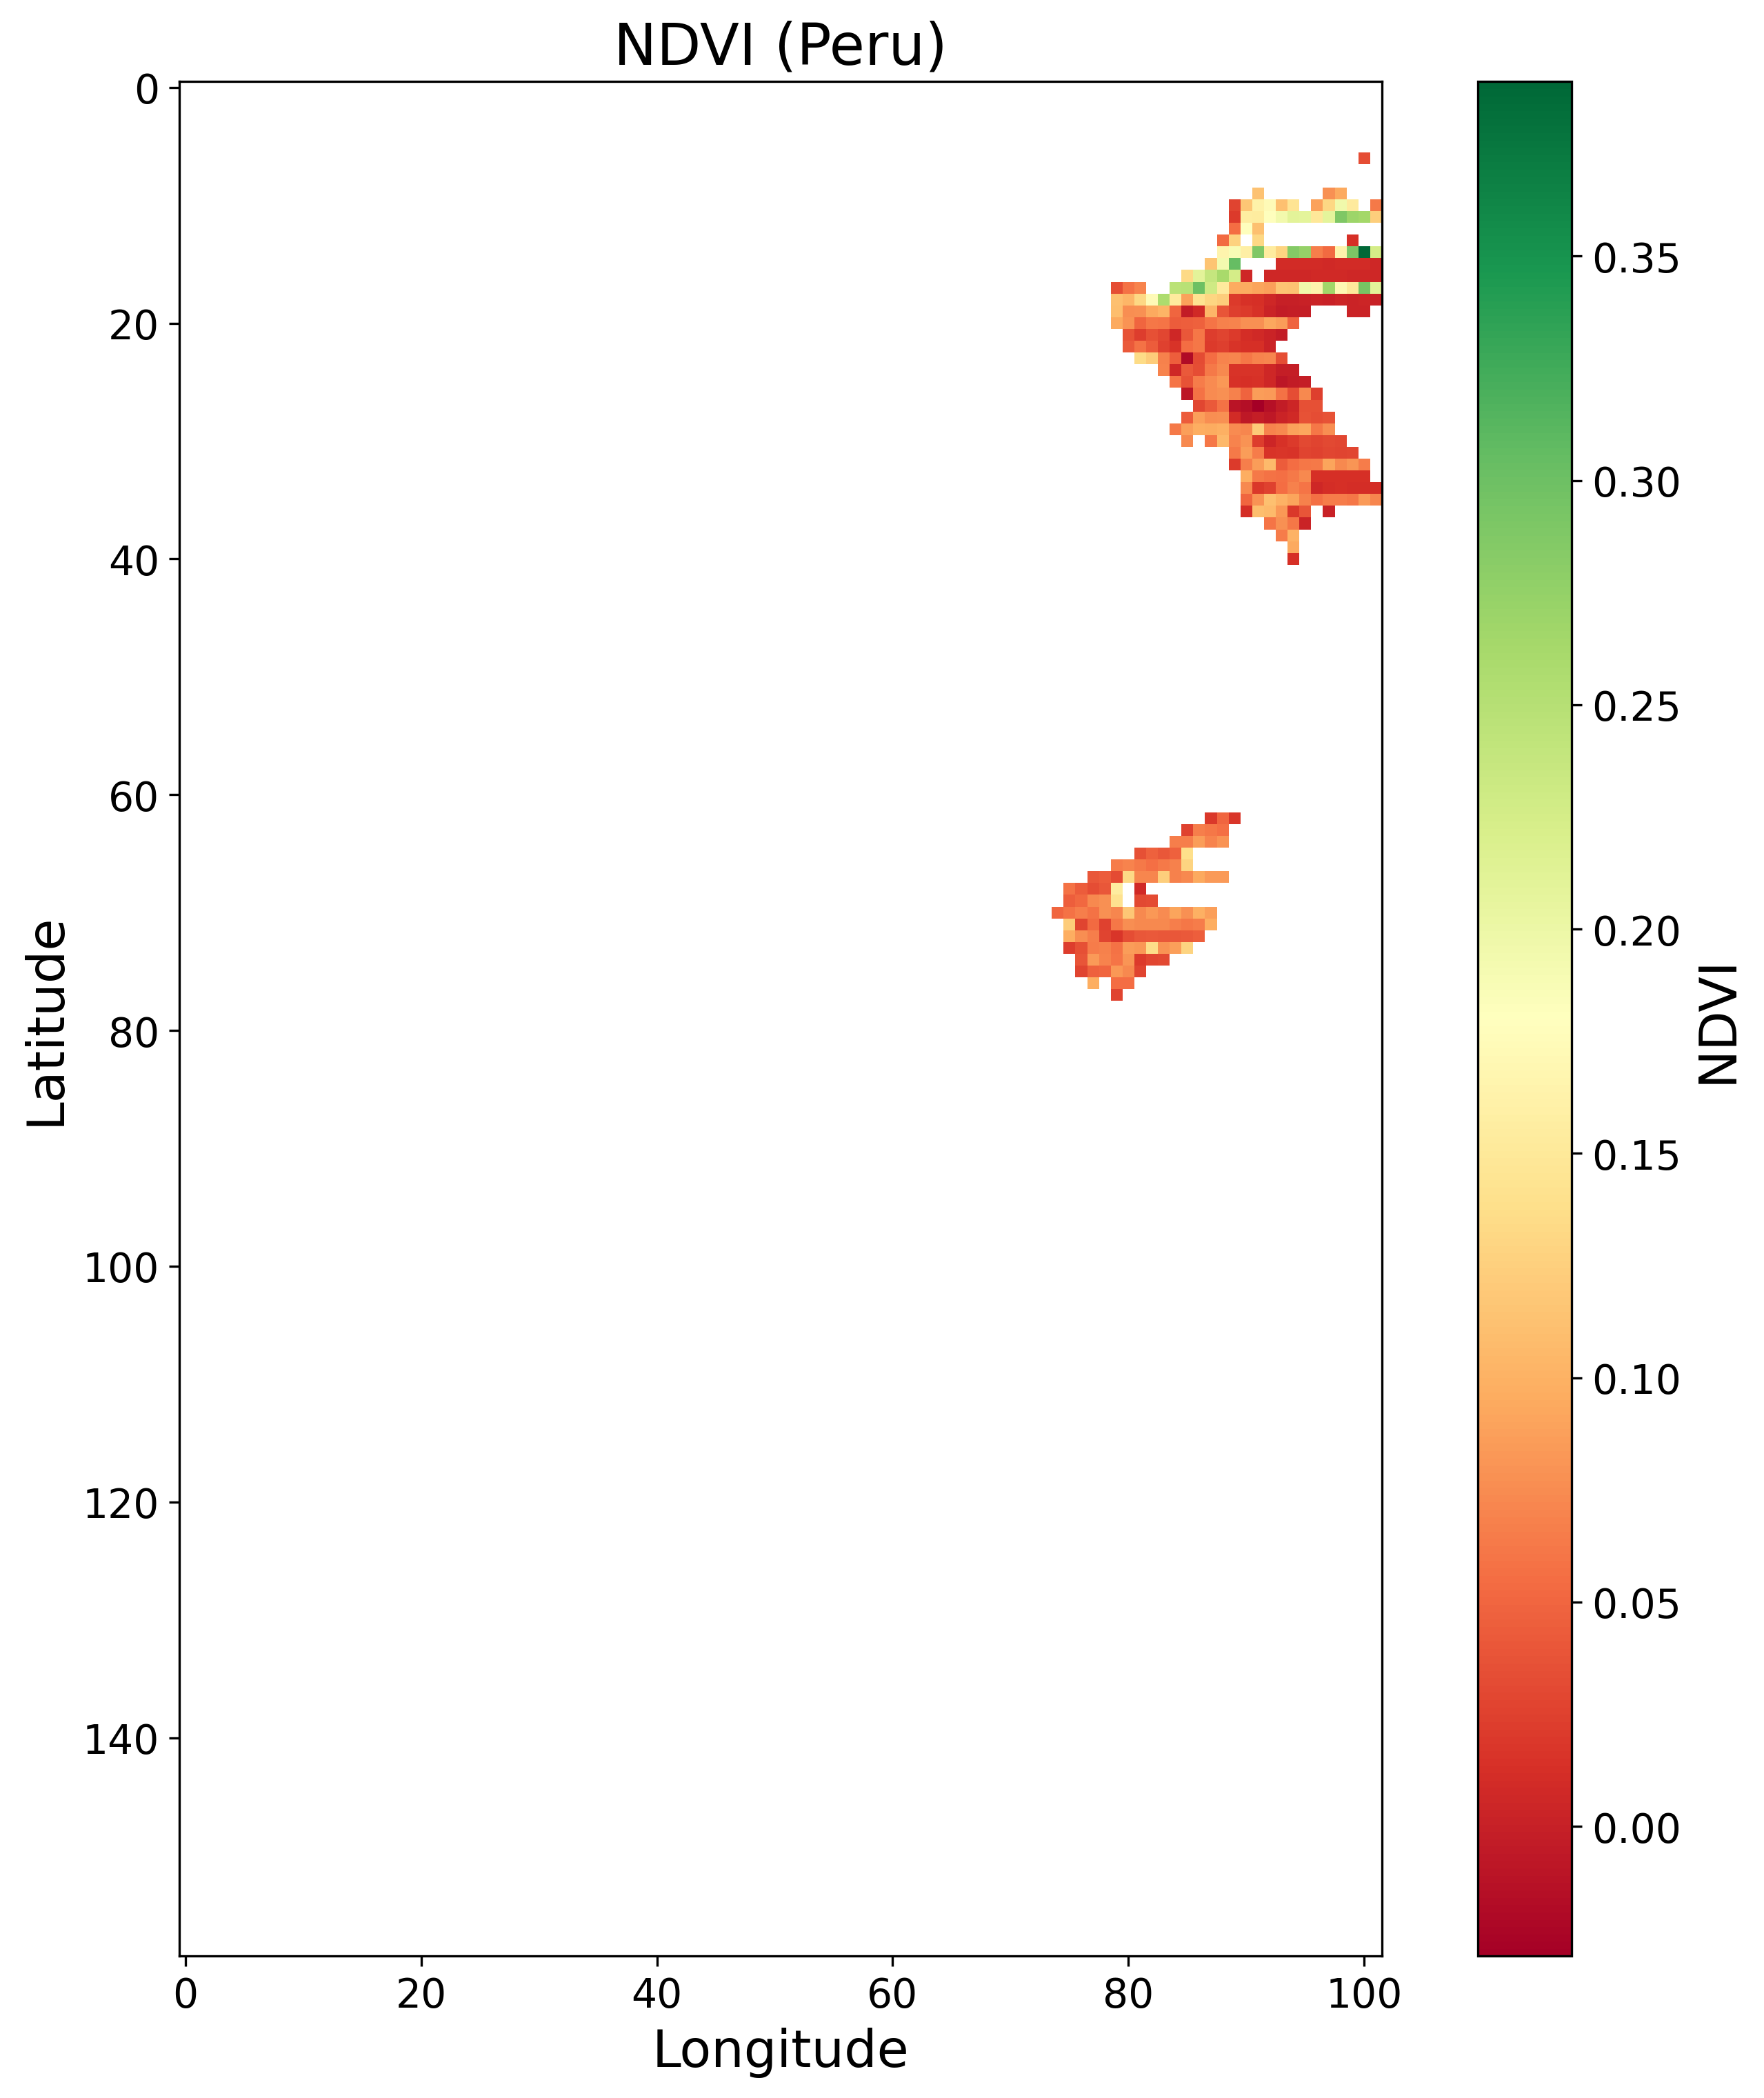

In [9]:
buffer_dataset = ls_data.where(buffer_mask, other=np.nan)#.astype("int16")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ndvi_composite = NDVI(create_median_mosaic(buffer_dataset, nodata=np.nan)).persist()

from utils.data_cube_utilities.dc_rgb import rgb

fig, axes = plt.subplots(nrows=1, figsize=(12, 12))

composite_buffer_mask = buffer_mask.median(dim='time').astype('bool')
composite_buffer_mask = xr.ufuncs.logical_not(composite_buffer_mask)

land_and_water_composite = create_median_mosaic(ls_data, no_data=np.nan)

extent = [ndvi_composite.longitude.min(),
      ndvi_composite.longitude.max(),
      ndvi_composite.latitude.min(),
      ndvi_composite.latitude.max()]
buffers = np.ma.masked_where(composite_buffer_mask, ndvi_composite)
#     rgb(land_and_water_composite.sel(river_section), bands=['nir', 'swir1', 'red'], ax=axes[i],
#         imshow_kwargs=dict(vmin=0, vmax=5000))
im = axes.imshow(buffers, cmap='RdYlGn')
axes.grid(False)
axes.set_title(f'NDVI ({area_name})')
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')
ndvi_scale = fig.colorbar(im, ax=axes)
ndvi_scale.set_label('NDVI')
fig.savefig('ndvi_composite.png')

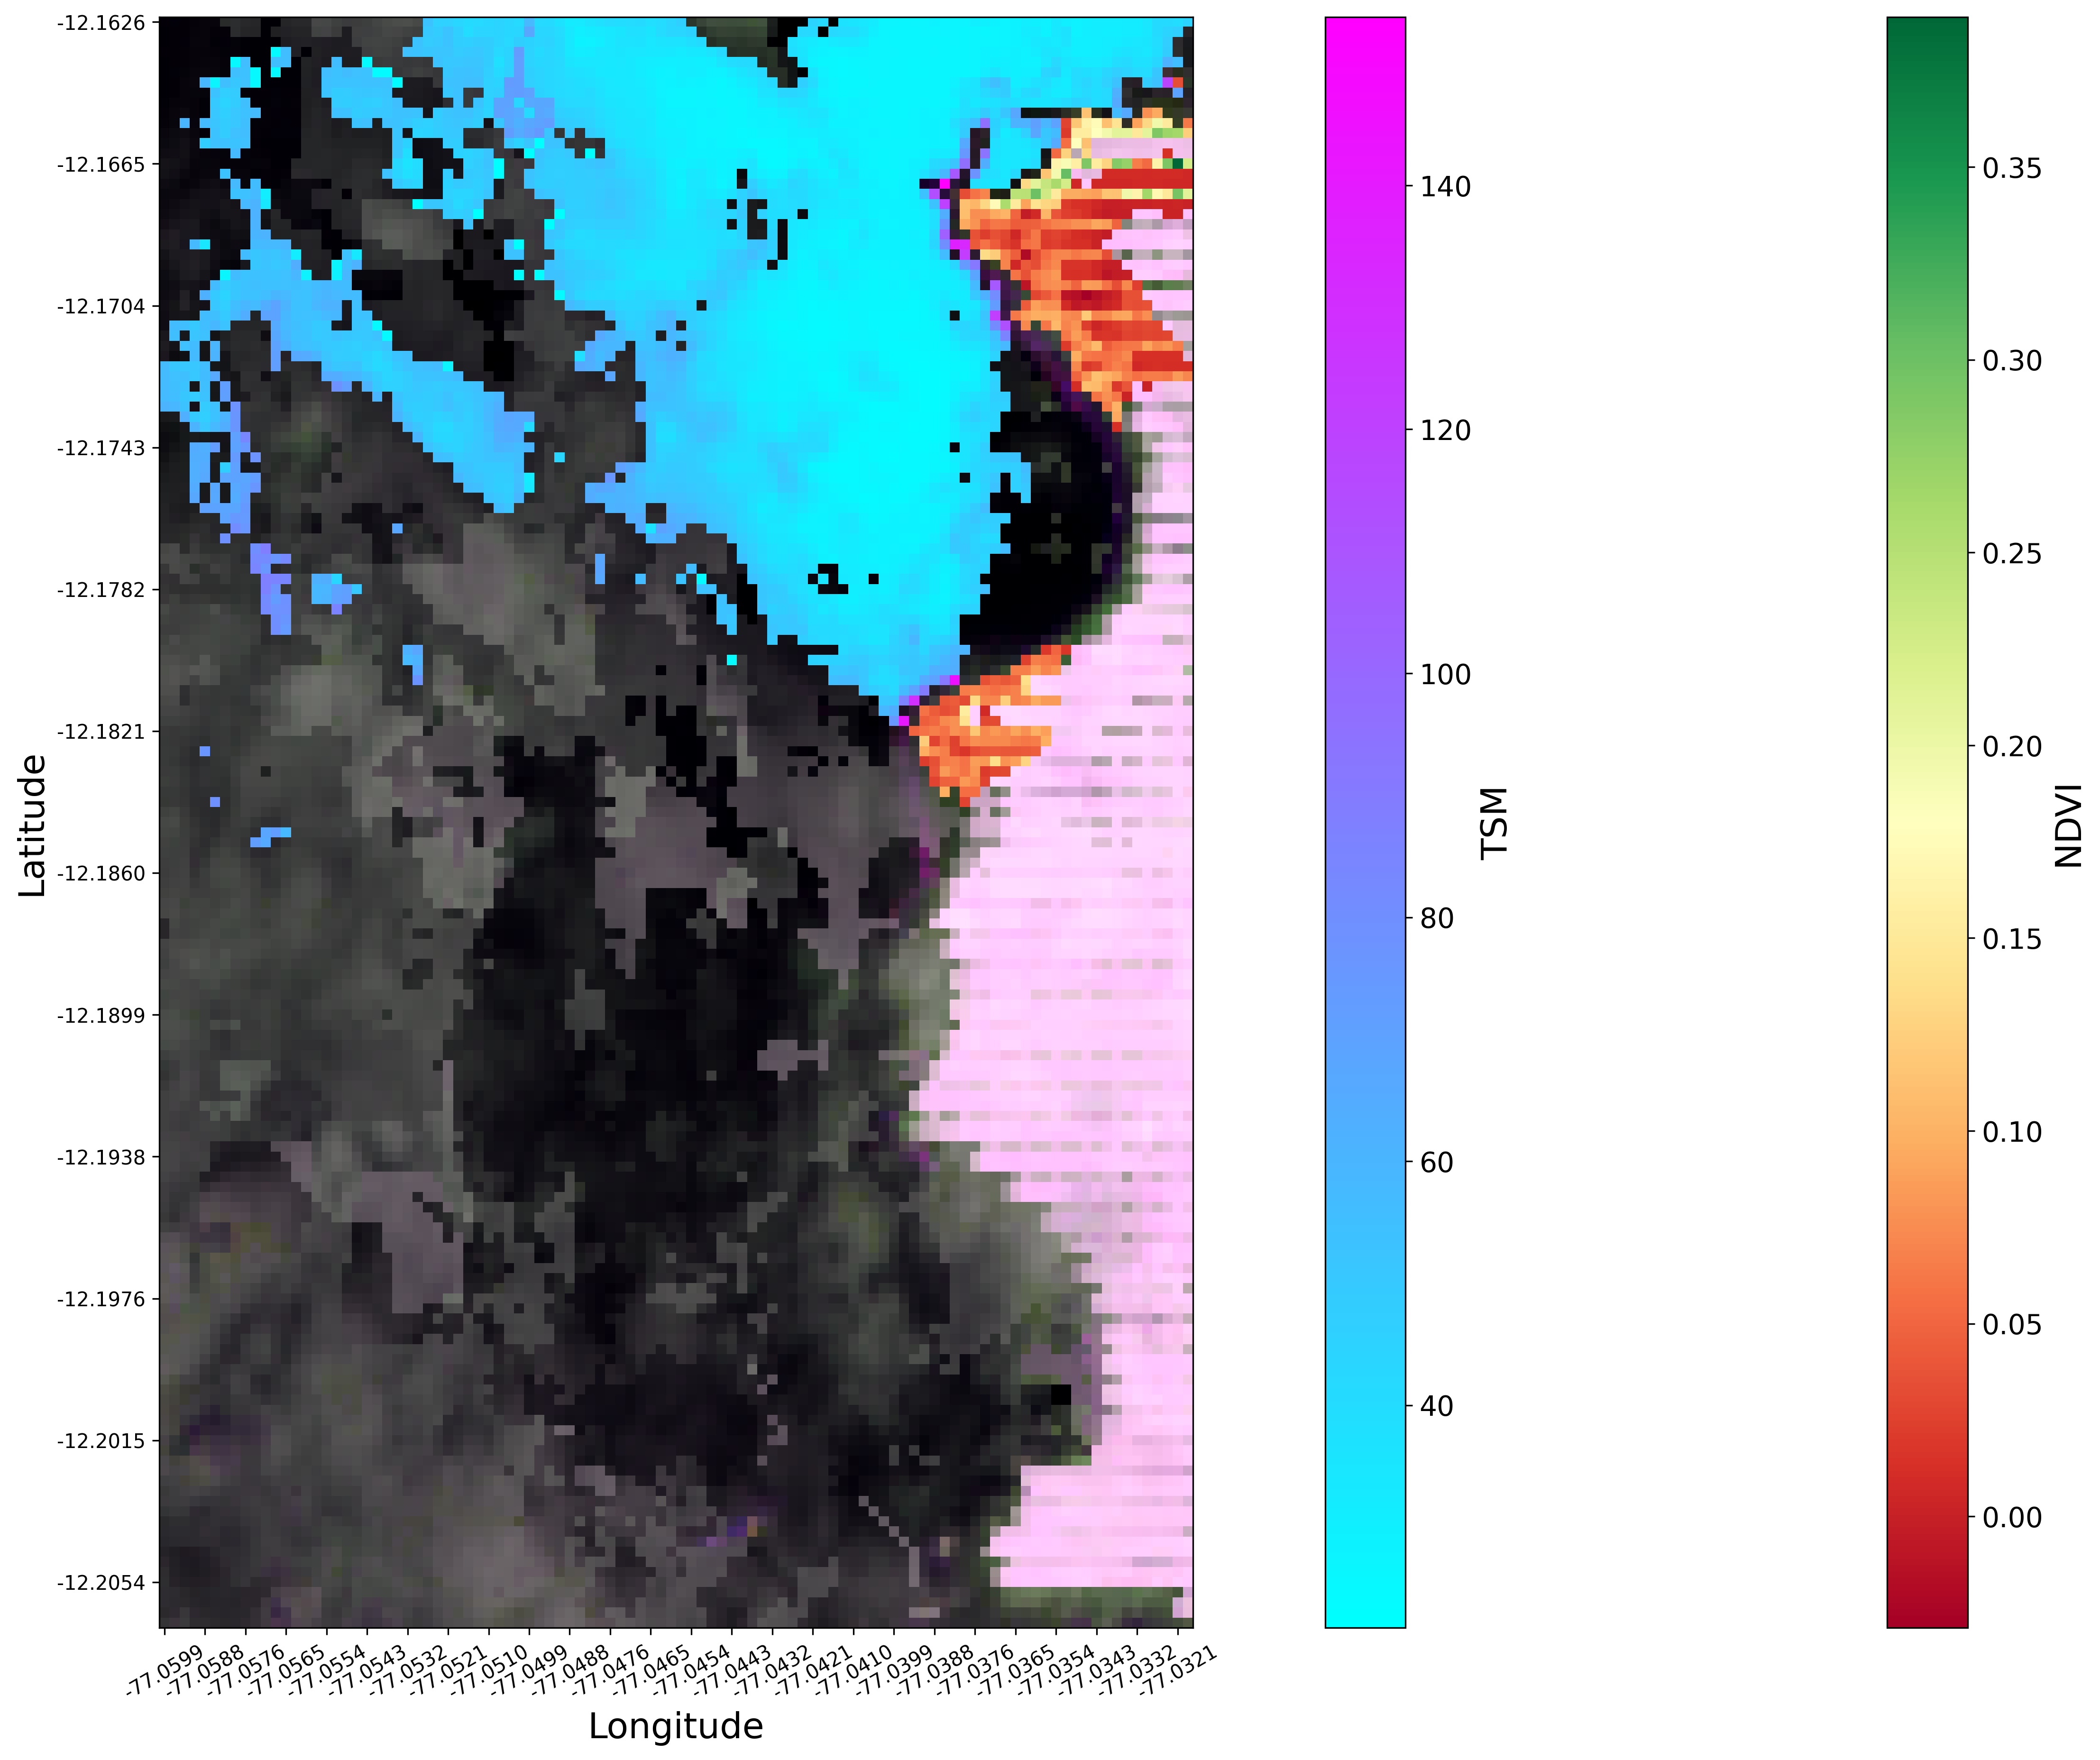

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(30, 15))

extent = [ndvi_composite.longitude.min(),
      ndvi_composite.longitude.max(),
      ndvi_composite.latitude.min(),
      ndvi_composite.latitude.max()]
buffers = np.ma.masked_where(composite_buffer_mask, ndvi_composite)
rgb(land_and_water_composite, bands=['nir', 'swir1', 'red'], ax=ax)
im = ax.imshow(buffers, cmap='RdYlGn')
ndvi_scale = fig.colorbar(im, ax=ax)
ndvi_scale.set_label('NDVI')
land_mask = xr.ufuncs.logical_not(water_mask)
composite_land_mask = land_mask.median(dim='time').astype('bool')
masked_tsm = np.ma.masked_where(composite_land_mask, mean_tsm_per_pixel.tsm)
im = ax.imshow(masked_tsm, cmap='cool')
ax.grid(False)
axes.set_title(f'NDVI over RGB ({area_name})')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
tsm_scale = fig.colorbar(im, ax=ax)
tsm_scale.set_label('TSM')
fig.savefig('tsm_ndvi_composite.png')

The image above is a composite of the mean Total Suspended Matter (TSM) and NDVI of the median composite. The water portion of the image represents TSM, with purple areas indicating higher amounts of suspended matter sensed from GIS observations.  The green areas along the coast indicate potential riparian vegetation.

## [References &#9652;](#Index)
---
[1] Cunningham, Kyle, et al. Riparian Buffers: Types and  Establishment Methods. p. 6.
(Cunningham, Stuhlinger, and Liechty, n.d.)

[2] Lowrance, Richard, et al. “Water Quality Functions of Riparian Forest Buffers in Chesapeake Bay Watersheds.” Environmental Management, vol. 21, no. 5, Sept. 1997, pp. 687–712. Crossref, doi:10.1007/s002679900060.

[3] The Elizabeth River Project, Paradise Creek Riparian Buffer Restoration (VA) Final Report.  March 2013.  Available https://www.nfwf.org/sites/default/files/finalreports1/24395_Final_Report.pdf Retrieved 8/28/2020

[4] Klemas, V. (2014). Remote sensing of riparian and wetland buffers: an overview. Journal of Coastal Research, 30(5), 869-880.

Prepared by Analytical Mechanics Associates for VMASC